# Experiment: Anwendung von N-Gramm-Regeln aus TinyStories auf Wikipedia

Dieses Experiment basiert auf der Arbeit von **Timothy Nguyen** und untersucht, wie gut N-Gramm-Regeln, die aus dem **TinyStories**-Datensatz extrahiert wurden, die **Vorhersagen eines Transformer-Modells** für einen **anderen Datensatz (Wikipedia)** approximieren können. Das Experiment wurde in einem Jupyter Notebook implementiert und die Ergebnisse werden visualisiert, um die Übertragbarkeit der Regeln zu testen.

## 1. Hintergrund

Im Originalpaper von **Nguyen et al.** wird untersucht, wie gut N-Gramm-Regeln die Vorhersagen von Transformer-basierten Modellen beschreiben können, insbesondere auf dem **TinyStories**-Datensatz. Diese Regeln werden auf das Modell angewendet, um deren **Vorhersagen zu approximieren**. Im vorliegenden Experiment wird diese Methodik auf **Wikipedia** angewendet, um zu testen, wie gut die Regeln aus einem anderen Datensatz (TinyStories) auf **fremden Text** übertragen werden können.

## 2. Ziele des Experiments

1. **TinyStories-Regeln auf Wikipedia anwenden**:
    - Berechnung der **Top-1 Accuracy** und **Variationsdistanz** zwischen den Modellvorhersagen und den N-Gramm-Regeln.
  
2. **Vergleich der Ergebnisse**:
    - **TinyStories** vs **Wikipedia**:
      - Vergleich der Modellvorhersagen auf dem eigenen Datensatz (TinyStories) und dem fremden Datensatz (Wikipedia) mit den N-Gramm-Regeln.

3. **Visualisierung der Ergebnisse**:
    - Darstellung der **Top-1 Accuracy** und der **Variationsdistanz** für beide Datensätze.
    - Vergleich der N-Gramm-Regeln auf beiden Datensätzen.

## 3. Vorgehensweise

### 3.1 Vorbereitung der Daten

- **Wikipedia-Daten**: 100 zufällige Sätze wurden aus dem **Wikipedia-Datensatz** (20220301.en) extrahiert und tokenisiert.
- **TinyStories-Daten**: N-Gramm-Regeln wurden aus den **TinyStories-Daten** extrahiert, um Vorhersagen zu erstellen und mit den Modellvorhersagen zu vergleichen.

### 3.2 Modellvorhersagen und Regelvorhersagen

- Für jeden Satz in Wikipedia und TinyStories wurde das **nächste Token** durch das Modell vorhergesagt.
- Es wurden ebenfalls **Regelvorhersagen** für das nächste Token berechnet, basierend auf den N-Gramm-Häufigkeiten aus den **TinyStories-Daten**.

### 3.3 Metriken

- **Top-1 Accuracy**: Wie oft stimmen die **Top-1 Vorhersagen** des Modells und der Regeln überein?
- **Variationsdistanz**: Wie ähnlich sind die Wahrscheinlichkeitsverteilungen der Modellvorhersagen und der Regelvorhersagen? (Berechnet mit dem L1-Abstand)

### 3.4 Visualisierung der Ergebnisse

Die Ergebnisse der Metriken für **TinyStories** und **Wikipedia** wurden in **Balkendiagrammen** visualisiert, um den **Vergleich der beiden Datensätze** zu zeigen.




In [3]:
from transformers import AutoModelForCausalLM
import torch
import sentencepiece as spm
import gcsfs
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Tokenizer-Pfad aus den Autorendaten
TOKENIZER_PATH = "gs://transformer-ngrams/32768.model"
LOCAL_TOKENIZER_PATH = "32768.model"
VOCAB_SIZE = 32768
BOS_TOKEN = 1


def download_tokenizer_from_gcs(gcs_path, local_path):
    """Lädt die SentencePiece-Tokenizer-Datei von GCS und speichert sie lokal."""
    print(f"Lade Tokenizer von GCS: {gcs_path} ...")
    
    fs = gcsfs.GCSFileSystem()  # GCS Zugriff
    with fs.open(gcs_path, 'rb') as gcs_file, open(local_path, 'wb') as local_file:
        local_file.write(gcs_file.read())  # Datei von GCS in eine lokale Datei schreiben

    print(f"Tokenizer erfolgreich heruntergeladen nach: {local_path}")


def load_author_tokenizer(tokenizer_path=TOKENIZER_PATH):
    """Lädt den SentencePiece-Tokenizer der Autoren."""
    print(f"Lade SentencePiece-Tokenizer von: {tokenizer_path}")
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(tokenizer_path)
    
    print("Autorentokenizer erfolgreich geladen!")
    return tokenizer

# Tokenizer herunterladen & laden
download_tokenizer_from_gcs(TOKENIZER_PATH, LOCAL_TOKENIZER_PATH)
tokenizer = load_author_tokenizer(LOCAL_TOKENIZER_PATH)
#Dekodierung zur Überprüfung
print(tokenizer.decode_ids([32599, 32600, 9, 375, 586]))
# Modellname 
MODEL_NAME = "dadosbon/TSModel2Try_continuation_1epoch"

def load_transformer_model(model_name=MODEL_NAME):
    """Lädt das Transformer-Modell und den Tokenizer."""
    print(f"Lade Transformer-Modell: {model_name} ...")
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    print("Modell erfolgreich geladen!")
    return model

# Modell und Tokenizer laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_transformer_model().to(device)


Lade Tokenizer von GCS: gs://transformer-ngrams/32768.model ...
Tokenizer erfolgreich heruntergeladen nach: 32768.model
Lade SentencePiece-Tokenizer von: 32768.model
Autorentokenizer erfolgreich geladen!
.,1 (ll
Lade Transformer-Modell: dadosbon/TSModel2Try_continuation_1epoch ...
Modell erfolgreich geladen!


# Wikipedia-Daten laden
Es werden **100 zufällige Artikel** aus dem **Wikipedia-Datensatz** (20220301.en) geladen. Diese Texte dienen dazu, die Übertragbarkeit der aus TinyStories abgeleiteten N-Gramm-Regeln auf Wikipedia zu testen.



In [4]:
from datasets import load_dataset
import random

# Wikipedia-Dataset laden (englisch, 20220301.en)
wiki_dataset = load_dataset("wikipedia", "20220301.en", split="train", trust_remote_code=True)

# 100 zufällige Artikel extrahieren
random.seed(42) #Reproduzierbarkeit
sampled_articles = random.sample(list(wiki_dataset), 100)

# Nur Text extrahieren
wiki_texts = [entry["text"] for entry in sampled_articles]


Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

# Satzextraktion und Tokenisierung
Die geladenen Wikipedia-Texte werden in **Einzelsätze** zerlegt. Anschließend wird eine Stichprobe von **100 zufälligen Sätzen** entnommen und tokenisiert, um sie für die Regel- und Modellvorhersagen vorzubereiten.

In [5]:
import re

def extract_sentences(text):
    """Zerlegt Text rudimentär in Sätze. Filtert sehr kurze Sätze heraus."""
    sentences = re.split(r'[.!?]\s+', text)
    return [s.strip() for s in sentences if len(s.strip().split()) > 5]  # nur längere Sätze mit >5 Wörtern

# Alle Sätze extrahieren
wiki_sentences = []
for text in wiki_texts:
    wiki_sentences.extend(extract_sentences(text))

# 100 zufällige Sätze wählen
wiki_sentences_sampled = random.sample(wiki_sentences, 100)

#tokenisieren der ersten 5 sätze als Beispiel
for i, sentence in enumerate(wiki_sentences_sampled[:5]):  # Beispiel: 5 Sätze prüfen
    tokens = tokenizer.encode_as_pieces(sentence)
    print(f"{i+1}: {sentence}")
    print(f"Tokens: {tokens}\n")


1: Thailand is hopeful that the government of the People's Republic of China will take measured actions that will soon bring back peace and harmony to the Tibet Autonomous Region in China
Tokens: ['Th', 'ailand', '▁is', '▁hopeful', '▁that', '▁the', '▁government', '▁of', '▁the', '▁People', "'", 's', '▁Republic', '▁of', '▁China', '▁will', '▁take', '▁measured', '▁actions', '▁that', '▁will', '▁soon', '▁bring', '▁back', '▁peace', '▁and', '▁harmony', '▁to', '▁the', '▁Tibet', '▁Aut', 'on', 'omous', '▁Region', '▁in', '▁China']

2: Presents (1956) (two episodes) - Lucy / Mrs
Tokens: ['P', 'resents', '▁(', '1', '9', '5', '6', ')', '▁(', 'two', '▁episodes', ')', '▁-', '▁Lucy', '▁/', '▁Mrs']

3: It is the main Kagyu temple
Tokens: ['It', '▁is', '▁the', '▁main', '▁K', 'ag', 'yu', '▁temple']

4: African-American history in Baltimore

School segregation in the United States
1956 in Maryland
Tokens: ['African', '-', 'American', '▁history', '▁in', '▁Baltimore', '\n', '\n', 'School', '▁segregation', '▁i

# Modellvorhersagen
Für jeden der **100 Wikipedia-Sätze** wird die Vorhersage des Transformers für das nächste Token berechnet. Zusätzlich wird die **vollständige Wahrscheinlichkeitsverteilung** (Softmax) pro Token gespeichert, um sie später mit den N-Gramm-Regeln zu vergleichen.

In [8]:
def predict_next_token(sentence: str, model, tokenizer):
    """
    Berechnet für jedes Token in einem Satz die Modellvorhersage für das nächste Token.
    Gibt zusätzlich die Wahrscheinlichkeitsverteilung zurück.
    """
     # Den Satz in Token umwandeln (einmal als lesbare Stücke und einmal als IDs)
    tokens = tokenizer.encode_as_pieces(sentence)  # SentencePiece-Tokenisierung
    token_ids = tokenizer.encode_as_ids(sentence)  # Token-IDs für numerischen Vergleich
    print(f"\n Satz: {sentence}")
    print(f"Tokenized: {tokens}")
    print(f"Token-IDs: {token_ids}\n")

    predictions = []

    for i in range(len(tokens) - 1):  # Letztes Token kann nicht vorhergesagt werden
        context_text = tokenizer.decode_pieces(tokens[:i+1]) 
        input_ids = tokenizer.encode_as_ids(context_text)
    
        input_tensor = torch.tensor([input_ids])  # ZUERST Tensor erstellen
        device = next(model.parameters()).device  # Modellgerät abfragen
        input_tensor = input_tensor.to(device)  # DANN verschieben
    
        with torch.no_grad():
            logits = model(input_tensor).logits
            probs = torch.nn.functional.softmax(logits[0, -1], dim=-1)
            predicted_token_id = torch.argmax(probs).item()
    
            predicted_token = tokenizer.decode_ids([predicted_token_id])
            ground_truth_id = token_ids[i+1]
    
        predictions.append({
            "context_token":tokens[:i+1],
            "context": context_text,
            "predicted_token": predicted_token,
            "predicted_token_id": predicted_token_id,
            "ground_truth": tokenizer.decode_ids([ground_truth_id]),
            "ground_truth_id": ground_truth_id,
            "probabilities": probs.cpu().numpy()  
        })

        print(f"Kontext: '{context_text}' → Modell: '{predicted_token}' (GT: '{tokenizer.decode_ids([ground_truth_id])}')")

    return predictions


all_predictions = []

for idx, sentence in enumerate(wiki_sentences_sampled):
    print(f"\nSatz {idx+1}/100:")
    predictions = predict_next_token(sentence, model, tokenizer)
    all_predictions.append(predictions)



Satz 1/100:

 Satz: Thailand is hopeful that the government of the People's Republic of China will take measured actions that will soon bring back peace and harmony to the Tibet Autonomous Region in China
Tokenized: ['Th', 'ailand', '▁is', '▁hopeful', '▁that', '▁the', '▁government', '▁of', '▁the', '▁People', "'", 's', '▁Republic', '▁of', '▁China', '▁will', '▁take', '▁measured', '▁actions', '▁that', '▁will', '▁soon', '▁bring', '▁back', '▁peace', '▁and', '▁harmony', '▁to', '▁the', '▁Tibet', '▁Aut', 'on', 'omous', '▁Region', '▁in', '▁China']
Token-IDs: [539, 14122, 328, 21461, 351, 280, 1710, 301, 280, 7012, 32619, 32585, 4826, 301, 3486, 481, 1040, 5750, 4606, 351, 481, 2371, 2102, 825, 3612, 305, 14106, 306, 280, 20885, 3720, 279, 13811, 12595, 304, 3486]

Kontext: 'Th' → Modell: '.' (GT: 'ailand')
Kontext: 'Thailand' → Modell: '.' (GT: ' is')
Kontext: 'Thailand is' → Modell: ' not' (GT: ' hopeful')
Kontext: 'Thailand is hopeful' → Modell: '.' (GT: ' that')
Kontext: 'Thailand is hopefu

# N-Gramm-Statistiken aus TinyStories laden
Die N-Gramm-Regeln werden aus den **offiziellen** TinyStories-Trainingsdaten der Autoren extrahiert. Dazu werden Parquet-Dateien von Google Cloud Storage geladen und daraus N-Gramm-Häufigkeiten (n = 1 bis 7) berechnet. Diese Statistiken bilden die Grundlage für die Regelvorhersagen.



In [9]:
import collections
import pandas as pd
from typing import List, Tuple


# Google Cloud Storage Einstellungen
GCS_BUCKET = 'gs://transformer-ngrams/TinyStories/train_data_rules'
fs = gcsfs.GCSFileSystem()

# N-Gramme aus Tokenliste erzeugen
def extract_ngrams(tokens: List[str], n: int) -> List[Tuple[str, ...]]:
    '''Erzeugt N-Gramme (Tupel aus n Tokens) aus einer gegebenen Tokenliste.'''
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]

def compute_ngram_statistics(official_data: List[List[str]], max_n: int = 7):
    '''Berechnet Häufigkeiten für N-Gramme (n=1 bis max_n) über gegebene Chunks und zeigt die Top 10 pro n.'''

    ngram_counts = collections.defaultdict(collections.Counter)

    for chunk in official_data:
        for n in range(1, max_n + 1):
            ngrams = extract_ngrams(chunk, n)
            print(f"Beispielhafte {n}-Gramme aus einem Chunk:", ngrams[:5])
            for ngram in ngrams:
                ngram_counts[n][ngram] += 1  

    # Zeigt die Top 10 häufigsten N-Gramme
    for n in range(1, 8):
        print(f"Top 10 der : {n}-Gramme mit Häufigkeiten:", ngram_counts[n].most_common(10))
    print("Erfasste N-Gramm-Stufen:", list(ngram_counts.keys()))
    return ngram_counts

# Lädt eine kleine Stichprobe der offiziellen Daten
def load_small_sample_from_official_data(sample_fraction=0.20, max_files=6, max_rows=5000):
    '''Lädt eine Stichprobe der offiziellen N-Gramm-Daten aus Parquet-Dateien in Google Cloud Storage.'''

    file_list = fs.ls(GCS_BUCKET)[:max_files]  # Lädt nur die ersten max_files Dateien
    df_list = []

    
    for file in file_list:
        if file.endswith(".parquet"):
            with fs.open(file) as f:
                df = pd.read_parquet(f, engine="pyarrow")
                
                # Begrenze Zeilenanzahl
                if len(df) > max_rows:
                    df = df.sample(n=max_rows, random_state=42)
                
                df_sample = df.sample(frac=sample_fraction, random_state=42)
                df_list.append(df_sample)
    
    if df_list:
        official_ngram_sample = pd.concat(df_list, ignore_index=True)
        print(f"Geladen: {len(official_ngram_sample)} Zeilen aus {len(file_list)} Dateien.")
        return official_ngram_sample
    else:
        print("Keine Daten geladen!")
        return None

official_data = load_small_sample_from_official_data(max_files=7, max_rows=5000, sample_fraction=0.25)

Geladen: 8750 Zeilen aus 7 Dateien.


# Regelverteilungen berechnen
Basierend auf den geladenen TinyStories-N-Gramm-Daten wird die **Regelverteilung 
pr(t∣C)** berechnet, also die relative Häufigkeit von Folgetokens. Diese Wahrscheinlichkeitsverteilung dient später zum Vergleich mit den Modellvorhersagen.



In [10]:
from collections import defaultdict

def compute_rule_distribution(next_token_counter: list):
    """Berechnet pr(t|C) = #{αt} / #{α*} aus next_token_counter."""
    token_counts = defaultdict(int)
    total_count = 0

    # next_token_counter = [token_id₁, count₁, token_id₂, count₂, ...]
    for i in range(0, len(next_token_counter), 2):
        token_id = next_token_counter[i]
        count = next_token_counter[i+1]
        token_counts[token_id] += count
        total_count += count

    if total_count == 0:
        return None  # Division durch 0 vermeiden

    # Wahrscheinlichkeitsverteilung: {token_id: Wahrscheinlichkeit}
    prob_dist = {token_id: count / total_count for token_id, count in token_counts.items()}
    return prob_dist

row = official_data.iloc[0]  # Beispiel: erste Zeile
rule_probs = compute_rule_distribution(row["next_token_counter"])

# Ausgabe als Top-5 Tokens
top5 = sorted(rule_probs.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top-5 Regelvorhersagen (Token-ID, Wahrscheinlichkeit):", top5)




Top-5 Regelvorhersagen (Token-ID, Wahrscheinlichkeit): [(np.int64(582), np.float64(1.0))]


# Vergleich: Modell vs. Regel
Hier wird die Vorhersage des Modells mit der Vorhersage der Regel verglichen. Zwei Metriken werden verwendet:

- Top-1 Accuracy $\frac{1}{N} \sum_{i=1}^{N} \mathbb{1} \left[ \arg\max_t \, \text{pr}_{\text{model}}(t \mid C_i) = \arg\max_t \, \text{pr}_{\text{rule}}(t \mid C_i) \right] 
$: Stimmen die wahrscheinlichsten Tokens überein?

- Variationsdistanz $
d(p, q) = \frac{1}{2} \sum_{\alpha} \left| p_\alpha - q_\alpha \right|
$: Differenz der Wahrscheinlichkeitsverteilungen   

In [11]:
import numpy as np

def compare_model_rule(model_probs: np.ndarray, rule_probs: dict):
    """
    Vergleicht Modellverteilung (p) und Regelverteilung (pr) anhand:
    - Top-1 Accuracy
    - Variationsdistanz
    """
    # Top-1 Token IDs
    model_top1 = np.argmax(model_probs)
    rule_top1 = max(rule_probs.items(), key=lambda x: x[1])[0]

    # Top-1 Accuracy
    top1_acc = int(model_top1 == rule_top1)

    # Regelverteilung in Vektorform
    rule_vec = np.zeros_like(model_probs)
    for token_id, prob in rule_probs.items():
        rule_vec[token_id] = prob

    # Variationsdistanz (1/2 * L1-Abstand)
    variational_distance = 0.5 * np.sum(np.abs(model_probs - rule_vec))

    return top1_acc, variational_distance

pred = all_predictions[0][0]  # Erster Satz, erstes Token
model_probs = pred["probabilities"]

row = official_data.iloc[0]  # Beispiel-Regel
rule_probs = compute_rule_distribution(row["next_token_counter"])

top1_acc, dist = compare_model_rule(model_probs, rule_probs)
print(f"Top-1 Accuracy: {top1_acc}, Distanz: {dist:.3f}")


Top-1 Accuracy: 0, Distanz: 0.999


# N-Gramm-Kontext → Modellvorhersage
Für ein konkretes **Beispiel** aus den TinyStories-N-Gramm-Daten wird der Kontext dekodiert und als Eingabe für das Modell verwendet. Damit kann die Modellverteilung für das nächste Token mit der Regelverteilung verglichen werden.

In [12]:
# Beispiel: Erste Zeile aus TinyStories N-Gramm-Daten
row = official_data.iloc[0]

# Kontext extrahieren und prüfen
context = row["context"]
if isinstance(context, np.ndarray):
    context = context.tolist()

print("Kontext-Tokens:", context)
print("Dekodierter Kontext:", tokenizer.decode_pieces(context))

# Satz dekodieren
sentence = tokenizer.decode_pieces(context)
token_ids = tokenizer.encode_as_ids(sentence)

print("Token-IDs:", token_ids)

if len(token_ids) == 0:
    print("Warnung: Tokenliste leer – Modell kann nicht berechnen.")
else:
    input_ids = torch.tensor([token_ids]).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        model_probs = torch.nn.functional.softmax(outputs.logits[0, -1], dim=-1).cpu().numpy()
    print("Modellvorhersage erfolgreich.")
    print("Top-Token ID:", np.argmax(model_probs))


Kontext-Tokens: [517, 537, 5761, 0, 4842, 996]
Dekodierter Kontext:  they were sharing helping each
Token-IDs: [517, 537, 5761, 4842, 996]
Modellvorhersage erfolgreich.
Top-Token ID: 582


# Metriken auf TinyStories: Modell vs. Regel
Für jede Regel aus den TinyStories-Daten wird die **zugehörige Modellvorhersage** berechnet und mit der Regelverteilung verglichen. Ziel ist es, die Top-1 Accuracy und Variationsdistanz als Maß für die Güte der Regelapproximation zu bestimmen.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Berechnung der Metriken für TinyStories
def compute_metrics_for_tinystories(official_data, model, tokenizer):
    top1_accuracies_tiny = []
    distances_tiny = []


    for idx, row in official_data.iterrows():
        # Berechne Regelvorhersagen (TinyStories)
        next_token_counter = row["next_token_counter"]
        rule_probs = compute_rule_distribution(next_token_counter)
        
        context = row["context"]
        # Überprüfe den Datentyp von row["context"] und konvertiere ihn bei Bedarf
        if isinstance(row["context"], np.ndarray):  # Falls es ein NumPy-Array ist
            context = context.tolist()

        # Wenn es sich um Tokenstücken handelt, dann decode_pieces() verwenden
        sentence = tokenizer.decode_pieces(context)  # Token-Stücke decodieren
        #print(f"Zeilenindex: {idx}")
        #print(f"Decoded Sentence: '{sentence}'")
        # sentence = tokenizer.decode_ids(row["context"])

        token_ids = tokenizer.encode_as_ids(sentence)
        #print(f"Token-IDs: {token_ids} (Länge: {len(token_ids)})")

        if len(token_ids) == 0:
            print("Leerer Satz – wird übersprungen.")
            continue

            


        # Modellvorhersagen für TinyStories
        # Tokenisiere den Satz und wandle ihn in Token-IDs um
        # Verwende 'encode_as_ids', um die Token-IDs zu bekommen und dann in einen Tensor umzuwandeln
        input_ids = torch.tensor([tokenizer.encode_as_ids(sentence)]).to(device)  # Umwandlung in Tensor

        
        # Übergebe die Token-IDs an das Modell
        with torch.no_grad():
            outputs = model(input_ids)
            model_probs = torch.nn.functional.softmax(outputs.logits[0, -1], dim=-1).cpu().numpy()


        
        # Vergleiche Modell vs Regel
        top1_acc, dist = compare_model_rule(model_probs, rule_probs)
        top1_accuracies_tiny.append(top1_acc)
        distances_tiny.append(dist)
    
    return top1_accuracies_tiny, distances_tiny


top1_accuracy_tiny, distances_tiny = compute_metrics_for_tinystories(official_data, model, tokenizer)




Leerer Satz – wird übersprungen.
Leerer Satz – wird übersprungen.


# TinyStories-Regeln auf Wikipedia anwenden
Für **jede** Modellvorhersage auf Wikipedia wird geprüft, ob es in den TinyStories-Daten eine **passende** N-Gramm-Regel gibt (Suffix-Match des Kontexts). Die Regel mit der **geringsten** Variationsdistanz zur Modellverteilung wird ausgewählt und deren Top-1 Accuracy sowie Distanz gespeichert.



In [14]:
def find_best_matching_rule(wiki_context_tokens: List[str], official_data, tokenizer, model_probs):
    """Findet die TinyStories-Regel mit geringster Variationsdistanz zur Modellvorhersage."""

    best_dist = float('inf')
    best_top1 = 0
    best_rule_probs = None

    for _, row in official_data.iterrows():
        # Extrahiere Regel-Kontext und Wahrscheinlichkeiten
        rule_context_tokens = row["context"]
        if isinstance(rule_context_tokens, np.ndarray):
            rule_context_tokens = rule_context_tokens.tolist()

        # Regel-Kontext zu String → für Vergleich
        rule_context_str = " ".join(tokenizer.decode_ids(rule_context_tokens).split())

        wiki_context_str = " ".join(tokenizer.decode_ids(wiki_context_tokens[-len(rule_context_tokens):]).split())


        # Grober Matching-Vergleich: passt TinyStories-Kontext zum Wikipedia-Kontext (Suffix-Match)?
        if rule_context_str == wiki_context_str:
            rule_probs = compute_rule_distribution(row["next_token_counter"])
            if rule_probs is None:
                continue

            # Vergleich Modell vs Regel
            top1_acc, dist = compare_model_rule(model_probs, rule_probs)

            if dist < best_dist:
                best_dist = dist
                best_top1 = top1_acc
                best_rule_probs = rule_probs

    return best_top1, best_dist, best_rule_probs

# 2. Berechnung der Metriken für Wikipedia 
top1_accuracy_wiki = []
distances_wiki = []

top1_accuracy_wiki = []
distances_wiki = []

for preds in all_predictions:
    for pred in preds:
        model_probs = pred["probabilities"]

        # Verwende die gespeicherten echten Kontext-Tokens
        context_tokens = pred["context_token"]

        # Beste passende Regel aus TinyStories finden
        top1_acc, dist, _ = find_best_matching_rule(context_tokens, official_data, tokenizer, model_probs)

        if dist is not None:
            top1_accuracy_wiki.append(top1_acc)
            distances_wiki.append(dist)


# Visualisierung: TinyStories vs Wikipedia
Vergleich der **Top-1 Accuracy** und **Variationsdistanz** zwischen TinyStories und Wikipedia. Es wird überprüft, wie gut TinyStories-Regeln Modellvorhersagen im eigenen und im fremden Datensatz beschreiben.

TinyStories: Ø Top-1 Acc = 0.283, Ø Dist = 0.702
Wikipedia:   Ø Top-1 Acc = 0.059, Ø Dist = 0.675


C:\Users\larir\AppData\Local\Temp\ipykernel_23908\1505620576.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([filtered_distances_tiny, filtered_distances_wiki], labels=["TinyStories", "Wikipedia"])


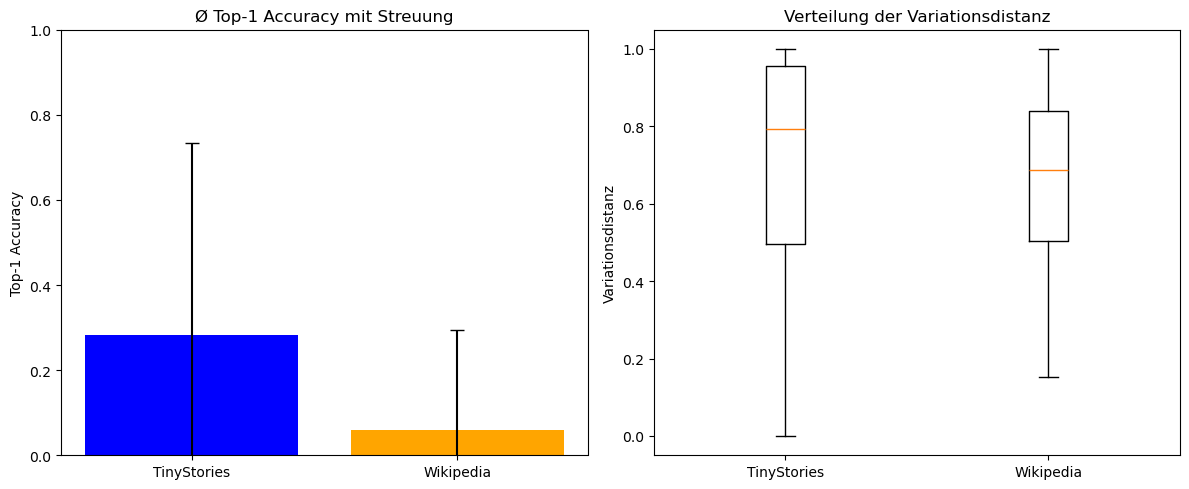

In [20]:
# 3. Visualisierung der Ergebnisse (Top-1 Accuracy und Variationsdistanz)
# Top-1 Accuracy Diagramm
import numpy as np
import matplotlib.pyplot as plt

# Mittelwerte & Standardabweichungen für Top-1 Accuracy
means_acc = [np.mean(top1_accuracy_tiny), np.mean(top1_accuracy_wiki)]
stds_acc = [np.std(top1_accuracy_tiny), np.std(top1_accuracy_wiki)]

# Filter für gültige Distanzwerte (Sicherheit)
filtered_distances_tiny = [d for d in distances_tiny if np.isfinite(d)]
filtered_distances_wiki = [d for d in distances_wiki if np.isfinite(d)]

# Mittelwerte berechnen
print(f"TinyStories: Ø Top-1 Acc = {np.mean(top1_accuracy_tiny):.3f}, Ø Dist = {np.mean(filtered_distances_tiny):.3f}")
print(f"Wikipedia:   Ø Top-1 Acc = {np.mean(top1_accuracy_wiki):.3f}, Ø Dist = {np.mean(filtered_distances_wiki):.3f}")                                                                    

# Plot
plt.figure(figsize=(12, 5))

# Links: Top-1 Accuracy Balken
plt.subplot(1, 2, 1)
plt.bar(["TinyStories", "Wikipedia"], means_acc, yerr=stds_acc, capsize=5, color=["blue", "orange"])
plt.ylabel("Top-1 Accuracy")
plt.title("Ø Top-1 Accuracy mit Streuung")
plt.ylim(0, 1)

# Rechts: Variationsdistanz Boxplot
plt.subplot(1, 2, 2)
plt.boxplot([filtered_distances_tiny, filtered_distances_wiki], labels=["TinyStories", "Wikipedia"])
plt.ylabel("Variationsdistanz")
plt.title("Verteilung der Variationsdistanz")

plt.tight_layout()
plt.show()


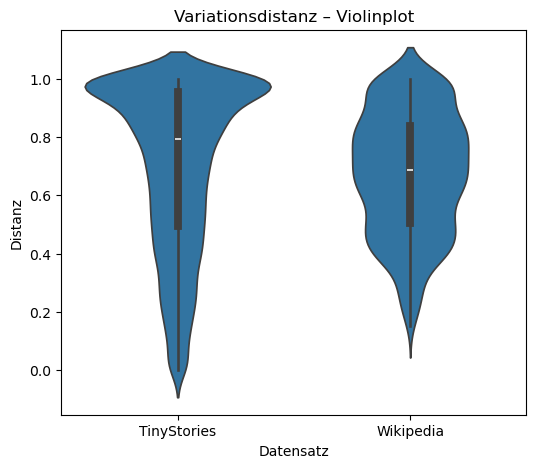

In [26]:
import seaborn as sns

# Daten vorbereiten
import pandas as pd
df = pd.DataFrame({
    "Distanz": filtered_distances_tiny + filtered_distances_wiki,
    "Datensatz": ["TinyStories"] * len(filtered_distances_tiny) + ["Wikipedia"] * len(filtered_distances_wiki)
})

# Violinplot
plt.figure(figsize=(6, 5))
sns.violinplot(x="Datensatz", y="Distanz", data=df)
plt.title("Variationsdistanz – Violinplot")
plt.show()


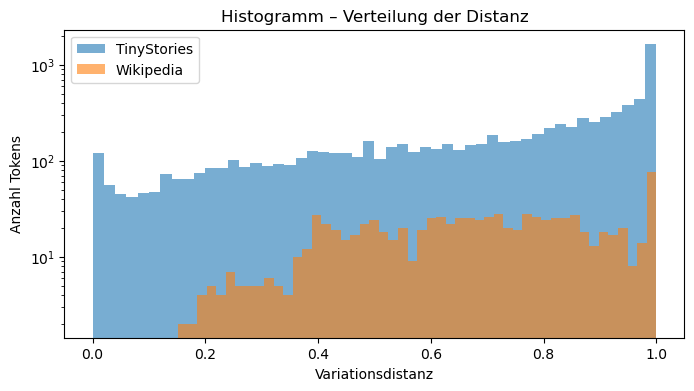

In [24]:
plt.figure(figsize=(8, 4))
plt.hist(filtered_distances_tiny, bins=50, alpha=0.6, label="TinyStories")
plt.hist(filtered_distances_wiki, bins=50, alpha=0.6, label="Wikipedia")
plt.xlabel("Variationsdistanz")
plt.ylabel("Anzahl Tokens")
plt.title("Histogramm – Verteilung der Distanz")
plt.yscale("log")

plt.legend()
plt.show()


# Zusammenfassung
Auswahl und Anwendung der N-Gramm-Regeln
In diesem Experiment wird die bestmögliche Approximation der Modellvorhersagen durch N-Gramm-Regeln aus dem TinyStories-Datensatz untersucht. Dazu werden alle verfügbaren Regeln aus den offiziellen Daten einbezogen, unabhängig davon, ob sie auf reinen Suffixen $R_{\text{suffix}}$, Teilkontexten $R_{\text{subgram}}$ oder auch marginalisierten Kontexten $R_{\text{all}}$ basieren.

Konkret wird für jede Modellvorhersage auf Wikipedia diejenige TinyStories-Regel gesucht, deren Vorhersage die geringste Variationsdistanz zur Modellverteilung aufweist. Dies entspricht methodisch dem Ansatz aus dem Paper, bei dem die bestmögliche Regel aus dem gesamten Regelraum Rallₘ ausgewählt wird (vgl. Paper, Tabelle 2).
Begründung:
Da die Regeln in den offiziellen Daten bereits vorgegeben sind und nicht explizit klassifiziert wurden, wird keine Einschränkung auf spezifische Regeltypen vorgenommen. Ziel ist es vielmehr, zu analysieren, wie gut TinyStories-Regeln generell auf Wikipedia übertragbar sind, wenn man stets die beste verfügbare Regel auswählt.

Dieser Ansatz liefert eine obere Schranke der Approximation durch N-Gramm-Regeln und erlaubt so eine fundierte Einschätzung der Übertragbarkeit einfacher statistischer Regeln auf fremde Domänen.

# Auswertung der Ergebnisse
Ziel dieses Experiments war es, zu untersuchen, wie gut N-Gramm-Regeln, die aus dem TinyStories-Datensatz extrahiert wurden, die Vorhersagen eines Transformer-Modells approximieren können – sowohl auf dem originalen TinyStories-Kontext als auch auf fremden Wikipedia-Daten.

**TinyStories** (eigener Datensatz)
- Ø Top-1 Accuracy: **0.283**
- Ø Variationsdistanz: **0.702**

Die Regeln erzielen auf TinyStories eine mäßige Top-1 Accuracy, treffen also in rund 28 % der Fälle die gleiche Vorhersage wie das Modell. Die durchschnittliche Variationsdistanz ist mit 0.702 relativ hoch, was darauf hindeutet, dass die Regelverteilungen und Modellverteilungen häufig deutlich voneinander abweichen. Dies ist konsistent mit den Ergebnissen aus dem Paper, das zeigt, dass einfache N-Gramm-Regeln transformerbasierte Verteilungen nur näherungsweise beschreiben können.

**Wikipedia** (fremder Datensatz)
- Ø Top-1 Accuracy: **0.059**
- Ø Variationsdistanz: **0.675**

Auf Wikipedia sinkt die Top-1 Accuracy drastisch auf etwa 6 %. Die Regeln aus TinyStories treffen also fast nie die Vorhersage des Modells auf Wikipedia-Daten. Interessanterweise ist die Variationsdistanz hier niedriger als bei TinyStories, was zunächst kontraintuitiv erscheint.

Diese geringere Distanz entsteht jedoch, weil viele Regelverteilungen auf Wikipedia flach und unspezifisch sind. Sie ähneln zufällig den (ebenfalls unspezifischen) Modellverteilungen in neuen Kontexten, was zu einer geringeren Differenz führt – ohne tatsächliche inhaltliche Übereinstimmung.

# Interpretation
Die höhere Distanz auf TinyStories zeigt, dass Regeln oft präzise, aber falsch sind (z. B. Vorhersage mit hoher Wahrscheinlichkeit, aber falsches Token).

Die niedrigere Distanz auf Wikipedia ist nicht Ausdruck besserer Passung, sondern eher ein Zeichen für unspezifische, verwaschene Verteilungen, die zufällig näher beieinanderliegen.

# Fazit
Die Ergebnisse bestätigen, dass N-Gramm-Regeln Transformer-Vorhersagen auf bekannten Daten nur eingeschränkt beschreiben. Auf fremden Daten versagen sie fast vollständig, auch wenn die Distanz scheinbar besser ist. Top-1 Accuracy ist daher die entscheidendere Metrik zur Bewertung der Regelübertragbarkeit.

